In [1]:
# --- Imports ---
import pandas as pd
import re
import contractions
import emoji
import nltk
import joblib

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

import matplotlib.pyplot as plt
from tqdm import tqdm

# --- NLTK Downloads ---
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("C:/Users/eliza/Documents/Semester VI/ELIZA SEMANGAT/medical_data.csv")
df

C:\Users\eliza\AppData\Local\Temp\ipykernel_12204\173311024.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/eliza/Documents/Semester VI/ELIZA SEMANGAT/medical_data.csv")


,user_id,username,time,rating,original_text,translated_text,final_with_stopword,final_no_stopword,ori_wc,final_wc,...,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21
0,1.144028e+20,Sajida Dar,1583977664092,5.0,"Great people,great staff and great facility to...","Great people,great staff and great facility to...",great people great staff and great facility to...,great people great staff great facility go thu...,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.027817e+20,Tamara Walker,1604380776309,2.0,Security guard asked me to put a mask on my 13...,Security guard asked me to put a mask on my 13...,security guard ask me to put a mask on my 13 m...,security guard ask put mask 13 month old baby ...,65,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,39,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.108501e+20,Keegan Leahy,1581384638564,1.0,Front of house has amazing staff.. Owner howev...,Front of house has amazing staff.. Owner howev...,front of house have amazing staff owner howeve...,front house amazing staff owner however lot gr...,51,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.106635e+20,Kyle Ebert,1592438884887,2.0,Came in early\nNo one was there except one per...,Came in early\nNo one was there except one per...,come in early no one be there except one perso...,come early no one except one person need simpl...,60,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316339,1.020788e+20,Kevin Portee,1577891990033,5.0,I feel like a new person on every visit,I feel like a new person on every visit,i feel like a new person on every visit,feel like new person every visit,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316340,1.143790e+20,James Rose,1522868195876,5.0,The aqua therapy I have been receiving there h...,The aqua therapy I have been receiving there h...,the aqua therapy i have be receive there have ...,aqua therapy receive helpful,12,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316341,1.015381e+20,Maxwell Rosa,1540950220650,5.0,Had baby #1 last year in June. Staff was amaz...,Had baby #1 last year in June. Staff was amaz...,have baby 1 last year in june staff be amaze s...,baby 1 last year june staff amaze shoutout mid...,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316342,1.028744e+20,Yolonda Taylor,1536770366671,1.0,I gave the staff my authorization number for m...,I gave the staff my authorization number for m...,i give the staff my authorization number for m...,give staff authorization number botox injectio...,116,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**PREPROCESSING**

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

def preprocess(text):
    if not isinstance(text, str): return []
    text = contractions.fix(text)
    text = emoji.replace_emoji(text, '')
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged
        if word not in stop_words and len(word) > 1 and word.isalpha()
    ]

df["tokens"] = df["translated_text"].apply(preprocess)
df = df[df["tokens"].str.len() >= 3]
processed_texts = df["tokens"].tolist()


In [4]:
df

,user_id,username,time,rating,original_text,translated_text,final_with_stopword,final_no_stopword,ori_wc,final_wc,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
0,1.144028e+20,Sajida Dar,1583977664092,5.0,"Great people,great staff and great facility to...","Great people,great staff and great facility to...",great people great staff and great facility to...,great people great staff great facility go thu...,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[great, people, great, staff, great, facility,..."
1,1.027817e+20,Tamara Walker,1604380776309,2.0,Security guard asked me to put a mask on my 13...,Security guard asked me to put a mask on my 13...,security guard ask me to put a mask on my 13 m...,security guard ask put mask 13 month old baby ...,65,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[security, guard, ask, put, mask, month, old, ..."
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,39,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[one, good, cub, food, shop, everything, need,..."
3,1.108501e+20,Keegan Leahy,1581384638564,1.0,Front of house has amazing staff.. Owner howev...,Front of house has amazing staff.. Owner howev...,front of house have amazing staff owner howeve...,front house amazing staff owner however lot gr...,51,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[front, house, amazing, staff, owner, however,..."
4,1.106635e+20,Kyle Ebert,1592438884887,2.0,Came in early\nNo one was there except one per...,Came in early\nNo one was there except one per...,come in early no one be there except one perso...,come early no one except one person need simpl...,60,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[come, early, one, except, one, person, need, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316339,1.020788e+20,Kevin Portee,1577891990033,5.0,I feel like a new person on every visit,I feel like a new person on every visit,i feel like a new person on every visit,feel like new person every visit,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[feel, like, new, person, every, visit]"
316340,1.143790e+20,James Rose,1522868195876,5.0,The aqua therapy I have been receiving there h...,The aqua therapy I have been receiving there h...,the aqua therapy i have be receive there have ...,aqua therapy receive helpful,12,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[aqua, therapy, receive, helpful]"
316341,1.015381e+20,Maxwell Rosa,1540950220650,5.0,Had baby #1 last year in June. Staff was amaz...,Had baby #1 last year in June. Staff was amaz...,have baby 1 last year in june staff be amaze s...,baby 1 last year june staff amaze shoutout mid...,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[baby, last, year, june, staff, amaze, shoutou..."
316342,1.028744e+20,Yolonda Taylor,1536770366671,1.0,I gave the staff my authorization number for m...,I gave the staff my authorization number for m...,i give the staff my authorization number for m...,give staff authorization number botox injectio...,116,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[give, staff, authorization, number, botox, in..."


In [5]:
processed_texts

[['great', 'people', 'great', 'staff', 'great', 'facility', 'go'],
 ['security',
  'guard',
  'ask',
  'put',
  'mask',
  'month',
  'old',
  'baby',
  'say',
  'little',
  'two',
  'raise',
  'eyebrow',
  'ask',
  'mask',
  'baby',
  'please',
  'educate',
  'enforce',
  'policy',
  'defend',
  'cdc',
  'policy',
  'cloth',
  'face',
  'covering',
  'place',
  'young',
  'child',
  'age'],
 ['one',
  'good',
  'cub',
  'food',
  'shop',
  'everything',
  'need',
  'right',
  'even',
  'place',
  'sit',
  'relax',
  'eat',
  'drink',
  'coffee',
  'definitely',
  'cub',
  'check'],
 ['front',
  'house',
  'amazing',
  'staff',
  'owner',
  'however',
  'lot',
  'growth',
  'come',
  'professional',
  'communication',
  'way',
  'speak',
  'people',
  'excessive',
  'profanity',
  'belittle',
  'remark',
  'place',
  'engage',
  'customer',
  'behaviour',
  'blemish',
  'legal',
  'marijuana',
  'movement'],
 ['come',
  'early',
  'one',
  'except',
  'one',
  'person',
  'need',
  'sim

**TF-IDF**

In [6]:
#rejoin tokens back to single string
df['joined_tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

#create tf idf vectorizer
vectorizer = TfidfVectorizer(
    max_df=0.5, # equivalent to no_above = 0.5
    min_df=10, # equivalent to no_below = 10
    ngram_range = (1,1) # only consider single words
)
#create tf idf matrix = V MATRIX
tfidf = vectorizer.fit_transform(df['joined_tokens'])

#get vocab (words) for later inspection
feature_names = vectorizer.get_feature_names_out()

print(f"Shape of the TF-IDF matrix: {tfidf.shape}")
print(f"Number of unique tokens (features): {len(feature_names)}")

C:\Users\eliza\AppData\Local\Temp\ipykernel_12204\3787939197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['joined_tokens'] = df['tokens'].apply(lambda x: ' '.join(x))


Shape of the TF-IDF matrix: (310440, 14877)
Number of unique tokens (features): 14877


**CREATE DICTIONARY FOR COHERENCE**

In [7]:
dictionary = Dictionary(df["tokens"])


**NMF TRAINING AND COHERENCE**

In [8]:
def compute_nmf_coherence(tfidf, texts, dictionary, feature_names, start, limit, step):
    coherence_metrics = ['c_v', 'c_npmi', 'c_uci', 'u_mass']
    coherence_scores = {metric: [] for metric in coherence_metrics}
    model_list = []

    for k in tqdm(range(start, limit + 1, step), desc="Training NMF Models"):
        # --- Train NMF Model ---
        nmf_model = NMF(n_components=k, 
                        random_state=42, 
                        init='nndsvd', 
                        max_iter=500) # Increased max_iter for better convergence
        nmf_model.fit(tfidf)
        model_list.append(nmf_model)
        
        # --- Save Model ---
        joblib.dump(nmf_model, f"nmf_model_k{k}.joblib")

        # --- Extract Top Words ---
        topics = []
        for topic_weights in nmf_model.components_:
            top_words = [feature_names[i] for i in topic_weights.argsort()[:-11:-1]]
            topics.append(top_words)

        # --- Compute All Coherence Metrics ---
        for metric in coherence_metrics:
            cm = CoherenceModel(
                topics=topics,
                texts=texts,
                dictionary=dictionary,
                coherence=metric
            )
            coherence_scores[metric].append(cm.get_coherence())
            
    return model_list, coherence_scores

start, limit, step = 10, 140, 10
model_list, coherence_scores = compute_nmf_coherence(
    tfidf, processed_texts, dictionary, feature_names, start, limit, step
)


Training NMF Models: 100%|██████████| 14/14 [1:48:25<00:00, 464.67s/it]


**PLOT COHERENCE VS. K**

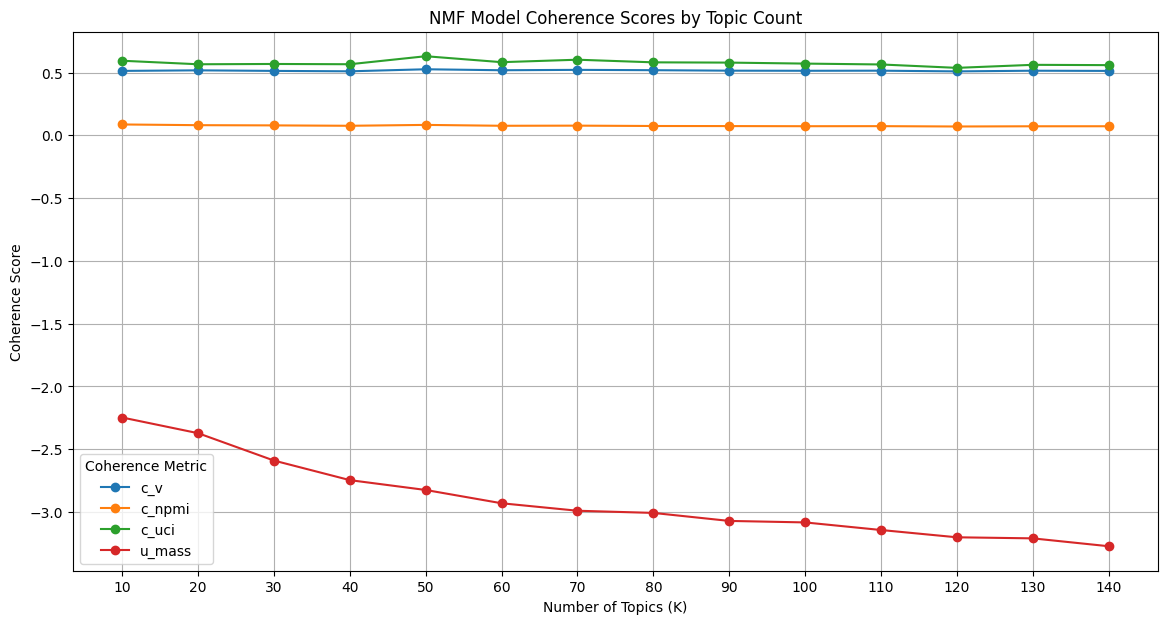

In [9]:
k_values = list(range(start, limit + 1, step))

plt.figure(figsize=(14, 7))

for metric, scores in coherence_scores.items():
    plt.plot(k_values, scores, marker='o', label=metric)

plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("NMF Model Coherence Scores by Topic Count")
plt.xticks(k_values)
plt.grid(True)
plt.legend(title="Coherence Metric")
plt.show()

**PRINT TOP WORDS FOR BEST MODEL**

In [11]:
# best_k_index = coherence_scores.index(max(coherence_scores))
# best_model = model_list[best_k_index]
# best_k = k_values[best_k_index]

# print(f"\nBest model: K = {best_k} with Coherence = {coherence_scores[best_k_index]:.4f}\n")

# def print_nmf_topics(model, feature_names, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
#         top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
#         print(f"Topic #{topic_idx+1}: {', '.join(top_features)}")

# print_nmf_topics(best_model, feature_names)

In [12]:

# Loop through each k value and its index
for i, k in enumerate(k_values):
    print(f"\nK = {k}")
    
    # Loop through each metric in the results dictionary
    for metric, scores in coherence_scores.items():
        # Get the score for the current k (at index i)
        score_for_k = scores[i]
        print(f"  {metric}: {score_for_k:.4f}")


K = 10
  c_v: 0.5134
  c_npmi: 0.0867
  c_uci: 0.5942
  u_mass: -2.2472

K = 20
  c_v: 0.5177
  c_npmi: 0.0811
  c_uci: 0.5662
  u_mass: -2.3721

K = 30
  c_v: 0.5134
  c_npmi: 0.0793
  c_uci: 0.5685
  u_mass: -2.5902

K = 40
  c_v: 0.5101
  c_npmi: 0.0762
  c_uci: 0.5664
  u_mass: -2.7460

K = 50
  c_v: 0.5263
  c_npmi: 0.0832
  c_uci: 0.6302
  u_mass: -2.8244

K = 60
  c_v: 0.5185
  c_npmi: 0.0762
  c_uci: 0.5828
  u_mass: -2.9302

K = 70
  c_v: 0.5216
  c_npmi: 0.0773
  c_uci: 0.6024
  u_mass: -2.9898

K = 80
  c_v: 0.5190
  c_npmi: 0.0745
  c_uci: 0.5815
  u_mass: -3.0071

K = 90
  c_v: 0.5151
  c_npmi: 0.0738
  c_uci: 0.5794
  u_mass: -3.0708

K = 100
  c_v: 0.5143
  c_npmi: 0.0728
  c_uci: 0.5715
  u_mass: -3.0828

K = 110
  c_v: 0.5150
  c_npmi: 0.0733
  c_uci: 0.5646
  u_mass: -3.1432

K = 120
  c_v: 0.5095
  c_npmi: 0.0705
  c_uci: 0.5375
  u_mass: -3.2012

K = 130
  c_v: 0.5148
  c_npmi: 0.0723
  c_uci: 0.5617
  u_mass: -3.2097

K = 140
  c_v: 0.5133
  c_npmi: 0.0725
  c_uci

In [13]:
def compute_nmf_topic_diversity(nmf_model, feature_names, topk=10):
    """
    Computes topic diversity for a Scikit-learn NMF model.

    Args:
        nmf_model: A trained Scikit-learn NMF model.
        feature_names (list): A list of words corresponding to the features.
        topk (int): The number of top words to consider for each topic.
    """
    topic_words = []
    for topic_weights in nmf_model.components_:
        # Get the indices of the top-k words for the current topic
        top_word_indices = topic_weights.argsort()[:-topk-1:-1]
        # Get the actual words from the feature names
        topic_words.append([feature_names[i] for i in top_word_indices])

    # The rest of the calculation is the same
    all_words = [word for topic in topic_words for word in topic]
    unique_words = set(all_words)
    
    if len(all_words) == 0:
        return 0.0
        
    return len(unique_words) / len(all_words)


diversity_scores = []

# Loop through each trained NMF model
for model in model_list:
    # Calculate diversity using the new function
    score = compute_nmf_topic_diversity(model, feature_names, topk=10)
    diversity_scores.append(score)

# Print the results, just like in your example
k_values = list(range(start, limit + 1, step))

print("--- NMF Topic Diversity Scores ---")
for i, k in enumerate(k_values):
    print(f"K = {k} → Topic Diversity: {diversity_scores[i]:.4f}")

--- NMF Topic Diversity Scores ---
K = 10 → Topic Diversity: 0.7600
K = 20 → Topic Diversity: 0.6450
K = 30 → Topic Diversity: 0.6233
K = 40 → Topic Diversity: 0.5825
K = 50 → Topic Diversity: 0.5700
K = 60 → Topic Diversity: 0.5400
K = 70 → Topic Diversity: 0.5286
K = 80 → Topic Diversity: 0.5062
K = 90 → Topic Diversity: 0.4844
K = 100 → Topic Diversity: 0.4700
K = 110 → Topic Diversity: 0.4709
K = 120 → Topic Diversity: 0.4642
K = 130 → Topic Diversity: 0.4600
K = 140 → Topic Diversity: 0.4514


## **BEST IS K = 10 & K = 50**  
**TOP WORDS FOR EACH**

In [15]:
def display_topics(model, feature_names, num_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:", end = "")
        #get top word indices and print corresponding words
        top_word_indices = topic.argsort()[:-num_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        print(", ".join(top_words))

model_k10 = model_list[0]
model_k50 = model_list[4]
# --- Display Top Words for K=10 ---
print("--- Top 10 Words for Model with K=10 ---")
display_topics(model_k10, feature_names, num_top_words=10)

print("\n" + "="*50 + "\n") # Separator

# --- Display Top Words for K=50 ---
print("--- Top 10 Words for Model with K=50 ---")
display_topics(model_k50, feature_names, num_top_words=10)


--- Top 10 Words for Model with K=10 ---
Topic 1:get, go, call, tell, back, say, would, never, doctor, could
Topic 2:friendly, staff, professional, helpful, knowledgeable, clean, efficient, quick, fast, super
Topic 3:wait, hour, time, long, appointment, minute, see, room, doctor, take
Topic 4:great, experience, place, staff, job, people, work, awesome, doctor, selection
Topic 5:good, store, price, grocery, selection, clean, food, high, shop, produce
Topic 6:service, customer, excellent, fast, bad, quick, poor, horrible, pharmacy, terrible
Topic 7:dr, care, recommend, highly, patient, professional, would, staff, take, doctor
Topic 8:dentist, dental, office, make, best, teeth, experience, go, kid, comfortable
Topic 9:nice, people, everyone, place, clean, really, helpful, super, store, employee
Topic 10:always, love, kid, place, go, helpful, year, smile, feel, come


--- Top 10 Words for Model with K=50 ---
Topic 1:go, back, year, else, never, anywhere, somewhere, beyond, way, definitely
